In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Separating Axis Theorem in 3D 

- two convex sets $\mathcal{A}$ and $\mathcal{B} \in \mathbb{R}^n$ do not intersect iff there exists a vector $\vec{n} \in \mathbb{R}^n$ such that the projections of $\mathcal{A}$ and $\mathcal{B}$ onto $\vec{n}$ are disjoint (i.e they dont overlap)
- Suppose $\mathcal{A} = \{\vec{a}_i\}$. Then the projection of $\mathcal{A}$ onto $\vec{n}$ is defined as $P_A = [\min_i(\vec{a}_i.\vec{n}),\max_j(\vec{a}_j.\vec{n})] = [a_{min},a_{max}]$
- Now we just need to check whether $[a_{min},a_{max}]$ overlaps with $[b_{min},b_{max}]$ i.e $\min(a_{max},b_{max}) - \max(a_{min},b_{min}) > 0$
- We should check for $\vec{n}$ equal to the face normals of $\mathcal{A}$ and $\mathcal{B}$ because separating planes are often parallel to faces
- We should also check for $\vec{n}$ equal to cross-product between edges of A and B to check for separating planes that are not parallel to the faces of A and B.
- the first step of the algorithm is to gather all such $\vec{n}$s and normalize them.
- then for each n, project A and B onto n to get $[a_{min},a_{max}]$ and $[b_{min},b_{max}]$
- evaluate $\delta = \min(a_{max},b_{max}) - \max(a_{min},b_{min})$
- if $\delta > 0$ then they intersect. Else they are separated.
- The smallest $\delta$ and $\vec{n}$ is the magnitude and direction of the minimum translation vector. i.e if you move A or B by $\delta\vec{n}$ you remove overlaps.
- 
- If $\mathcal{A}$ has $V_A$ vertices, $E_A$ edges, and $F_A$ faces. Then the time complexity is $O((F_A + F_B).(V_A + V_B) + (E_A.E_B).(V_A + V_B))$. The $(V_A + V_B)$ is the time-complexity for the projection operation. 


In [2]:
# verts is a numpy array of shape N*3
# faces is an array of indices indicating which vertices constitute the face

def face_normals_from_faces(verts, faces):
    # compute each face's normal
    normals = []
    for f in faces:
        if len(f) < 3: continue
        p0 = verts[f[0]]
        p1 = verts[f[1]]
        for k in range(2,len(f)):
            p2 = verts[f[k]]
            n = np.cross(p1-p0,p2-p0)
            if np.linalg.norm(n) > 1e-9:
                normals.append(n)
                break
    if len(normals) == 0:
        return np.zeros((0,3))
    return np.vstack(normals)

In [3]:
def edge_directions_from_faces(verts,faces):
    # return list of edge-vectors
    edges = []
    for f in faces:
        N = len(f)
        if N < 2: continue
        for i in range(N):
            a = verts[f[i]]
            b = verts[f[(i+1)%N]]
            e = b - a
            if np.linalg.norm(e) > 1e-9:
                edges.append(e)
    if len(edges) == 0:
        return np.zeros((0,3))
    return np.vstack(edges)


In [4]:
# normalize vectors
def unit_vector(v):
    norm = np.linalg.norm(v)
    if norm < 1e-9: return None
    return v/norm

In [5]:
# remove vectors that are colinear and normalize the rest
def remove_duplicates(axes):
    unique = []
    for a in axes:
        u = unit_vector(a)
        if u is None: continue

        for comp in u: # convention - first non-zero component > 0 so that +u and -u are equivalent and we can eliminate duplicates
            if abs(comp) > 1e-12:
                if comp < 0:
                    u = -u
            break

        # remove duplicates by comparing with unique
        is_unique = True
        for v in unique:
            dotprod = np.dot(u,v)
            if abs(dotprod) > 1.0 - 1e-9: # collinear
                keep = False
                break
        if is_unique:
            unique.append(u)
        if len(unique) == 0:
            return np.zeros((0,3))
        return np.vstack(unique)
            
            


In [6]:
# perform projection of point onto normal 
def project_onto_axis(verts, axis):
    # return [amin,amax]
    proj = verts.dot(axis)
    return proj.min(), proj.max()

# check if [amin,amax] overlaps with [bmin,bmax] and return delta
def delta_overlap(a_min, a_max, b_min, b_max):
    return min(a_max, b_max) - max(a_min, b_min)

In [7]:
def sat_intersect(vertsA, facesA, vertsB, facesB):
    # return (is_intersecting, axis, delta)

    # gather all axes
    normalsA = face_normals_from_faces(vertsA, facesA)
    normalsB = face_normals_from_faces(vertsB, facesB)
    edgesA = edge_directions_from_faces(vertsA, facesA)
    edgesB = edge_directions_from_faces(vertsB, facesB)

    # stack face normals
    axes = []
    if normalsA.shape[0]:axes.append(normalsA)
    if normalsB.shape[0]:axes.append(normalsB)
    
    if len(axes):
        axes = np.vstack(axes)
    else:
        axes = np.zeros((0,3))

    # cross products of edge pairs
    if edgesA.shape[0] and edgesB.shape[0]:
        crosses = []
        for ea in edgesA:
            for eb in edgesB:
                crossprod = np.cross(ea, eb)
                if np.linalg.norm(crossprod) > 1e-8:
                    crosses.append(crossprod)
        if len(crosses):
            axes = np.vstack([axes, np.vstack(crosses)])

    # remove duplicates and normalize the axes
    axes = remove_duplicates(axes)
    
    if axes.shape[0] == 0:
        # fallback - vector between centroids
        center_dir = np.mean(vertsB, axis=0) - np.mean(vertsA, axis=0)
        u = unit_vector(center_dir)
        if u is None:
            return False, None, None
        axes = np.vstack([u])

    # test all axes and evaluate delta and find min_delta and min_axis
    min_delta = np.inf
    min_axis = None
    for ax in axes:
        # projection
        a_min, a_max = project_onto_axis(vertsA, ax)
        b_min, b_max = project_onto_axis(vertsB, ax)
        delta = delta_overlap(a_min, a_max, b_min, b_max)
        if delta < 0:
            # found separating axis -> no intersection
            return False, None, None
        # keep smallest overlap (minimum translation)
        if delta < min_delta:
            min_delta = delta
            # direction: choose from A to B along axis
            # but we need sign so that moving A by axis * overlap separates them
            # compute center projections to decide sign
            centerA = 0.5*(a_min + a_max)
            centerB = 0.5*(b_min + b_max)
            sign = 1.0 if (centerB - centerA) >= 0 else -1.0
            vec_centers = np.mean(vertsB, axis=0) - np.mean(vertsA, axis=0)
            if np.dot(axis := ax, vec_centers) < 0:
                axis = -ax
            else:
                axis = ax
            min_axis = axis.copy()

    # no separating axis found -> intersection
    return True, min_axis, float(min_delta)


### Example - two unit cubes shifted 

Intersect: True
MTV axis: [0. 0. 1.] depth: 1.0


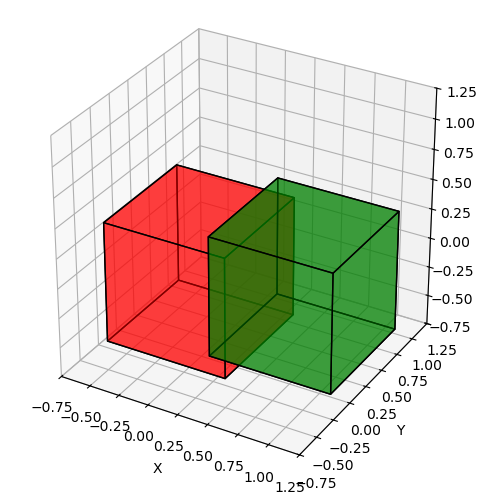

In [8]:
# two unit cubes, one centered at origin and the other one is shifted

# cube A centered at (0,0,0) size 1 (vertices and faces)
cube_verts = np.array([
    [-0.5,-0.5,-0.5],
    [ 0.5,-0.5,-0.5],
    [ 0.5, 0.5,-0.5],
    [-0.5, 0.5,-0.5],
    [-0.5,-0.5, 0.5],
    [ 0.5,-0.5, 0.5],
    [ 0.5, 0.5, 0.5],
    [-0.5, 0.5, 0.5]
])
cube_faces = [
    [0,1,2,3],
    [4,5,6,7],
    [0,1,5,4],
    [2,3,7,6],
    [1,2,6,5],
    [0,3,7,4],
]

A_verts = cube_verts
B_verts = cube_verts + np.array([0.75, 0.2, 0.0])  # shift second cube


inter, axis, depth = sat_intersect(A_verts, cube_faces, B_verts, cube_faces)
print("Intersect:", inter)
if inter:
    print("MTV axis:", axis, "depth:", depth)

# visualize these cubes
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

A_faces = [[A_verts[j] for j in face] for face in cube_faces]
B_faces = [[B_verts[j] for j in face] for face in cube_faces]

A_poly3d = Poly3DCollection(A_faces, facecolors='r', edgecolors='k', alpha=0.5)
B_poly3d = Poly3DCollection(B_faces, facecolors='g', edgecolors='k', alpha=0.5)
ax.add_collection3d(A_poly3d)
ax.add_collection3d(B_poly3d)

ax.set_box_aspect([1, 1, 1])
ax.set_xlim(-0.75, 1.25)
ax.set_ylim(-0.75, 1.25)
ax.set_zlim(-0.75, 1.25)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

